# Sensor calibration

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.fft import fft
import scipy.stats as stats
import csv
import glob
from datetime import datetime
from time import time

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

In [2]:
path = 'task_2_sensor_calibration/'

## Task 1: Analyze, interpret, and visualize the recorded signal as a function of oxygen concentration for each channel

The first problem to be solved is building up a data reading pipeline and coming up with a convenient data representation.

To this end, we first define the get_measurement_data function which reads the file and returns all the relevant data as a dictionary of parameters and arrays of measured values.

In [3]:
def get_measurement_data(filename): 
    """
    Read the measurement file and return the measurement parameters and data points.
    
    (also, check basic consistency for assumed format and contents)
    
    Input:
    filename - (str) name of the .csv file 
    
    Output:
    pars - (dictionary)
    time - (float array) [s]
    voltage - (float array) [V]
    current - (float array) [uA]
    potential - (float array) [V]
    """

   
    date_format='%d-%m-%Y %H:%M:%S'
    Npoints = 80

    pars = {}
    
    try:

        with open(filename, 'r') as file:
            csvF = csv.reader(file, delimiter=';')
            for i, line in enumerate(csvF):
                if i==0: # Date and time
                    pars['date'] = datetime.strptime(line[1].strip(), date_format)
                if i==1:
                    #pars['MFC1'] = np.float64(line[0].strip().strip('MFC1:').strip('sccm'))
                    pars['MFC1'] = np.float64((line[0].strip()[5:])[:-4])
                    #pars['MFC2'] = np.float64(line[1].strip().strip('MFC2:').strip('sccm'))
                    pars['MFC2'] = np.float64((line[1].strip()[5:])[:-4])
                    # print(f"{line[1]}->{pars['MFC2']}")
                    pars['t_huber'] = np.float64(line[2].strip().strip('t_huber:'))
                    pars['t_sht'] = np.float64(line[3].strip().strip('t_sht:'))
                    pars['h_sht'] = np.float64(line[4].strip().strip('h_sht:'))
                    pars['c_ox'] = pars['MFC2']*20.9/(pars['MFC1']+pars['MFC2'])

                if i==2:
                    pars['channel'] = line[1].strip().strip('channel:').strip()
                    pars['valve0'] = np.int32(line[2].strip().strip('valve0:'))
                    pars['valve1'] = np.int32(line[3].strip().strip('valve1:'))
                    pars['flow0'] = np.float64(line[4].strip().strip('flow0:'))
                    pars['flow1'] = np.float64(line[5].strip().strip('flow1:'))
                    pars['set_temp'] = np.float64(line[6].strip().strip('set_temp:'))
                    pars['set_RH'] = np.float64(line[7].strip().strip('set_RH:'))

                if i >= 3:
                    break

        df = pd.read_csv(filename, skiprows=[0, 1, 2], sep=';')
        df = df.rename(columns=lambda x: x.strip())
        
        column_names = ['Time', 'Voltage', 'Current', 'Unnamed: 3']
        
        for column_name in column_names:
            if len(df[column_name]) != 2*Npoints:
                print(f'Error in {os.path.basename(filename)}: inconsistent number of points.')
                raise Exception()
        
        for column_name in column_names[:2]:
            if not (np.array(df[column_name][0::2]) == np.array(df[column_name][1::2])).all():
                print(f'Error in {os.path.basename(filename)}: inconsistent {column_name} values.')
                raise Exception()
            
        if not (np.array(df['Unnamed: 3'][0::2]) == ' Current').all():
            print(f'Error in {os.path.basename(filename)}: inconsistent Current labels.')
            raise Exception()
            
        if not (np.array(df['Unnamed: 3'][1::2]) == ' CEPotential').all():
            print(f'Error in {os.path.basename(filename)}: inconsistent CEPotential labels.')
            raise Exception()
            
        
        time = np.array(df['Time'][0::2])
        voltage = np.array(df['Voltage'][0::2])
        current = np.array(df['Current'][0::2])
        potential = np.array(df['Current'][1::2])
        


        return pars, time, voltage, current, potential
    
    except Exception as ex:
        
        print(ex)

        
        return None, None, None, None, None


To conveniently work with measurement data, we define a simple Measurement class which gives us objects to conveniently store the data read from files.

The data read by the get_measurement_data function is directly mapped onto Measurement class objects, i.e. into pars, time, voltage, current and potential fields.

In [4]:
class Measurement():
    def __init__(self, filename):
        """
        .filename - (str) name of the file from which the data is read
        .pars - (dictionary) parameters returned by get_measurement_data
        .time - (float array) 'Time' column from filename (80 values)
        .voltage - (float array) 'Voltage' column from filename (80 values)
        .current - (float array) 'Current' column -> 'Current' spec (80 values)
        .potential - (float array) 'Current' column -> 'CEPotential' spec (80 values)
        """
        
        pars, time, voltage, current, potential = get_measurement_data(filename)
        
        if pars is None:
            print('Error creating a new Measurement!')

        self.filename = filename
        self.pars = pars
        self.time = time
        self.voltage = voltage
        self.current = current
        self.potential = potential
      
           
    def __str__(self):
        
        if self.pars is not None:
        
            s=80*'='
            s+=f'\nMeasurement filename: {os.path.basename(self.filename)}\n'
            s+=80*'='
        else:
            s = 'Invalid measurement'
        
        return s
        
    def __repr__(self):
        
        
        if self.pars is not None:
        
            s=80*'='
            s+=f'\nfilename: {os.path.basename(self.filename)}\n'
            s+=80*'-'
            for k in self.pars.keys():
                s+=f'\n{k}: {self.pars[k]}'


            s+=f'\n\nTime:'
            s+=f'\nMin: {np.min(self.time)}, Max: {np.max(self.time)}, Npoints: {len(self.time)}\n'

            s+=f'\nVoltage:'
            s+=f'\nMin: {np.min(self.voltage)}, Max: {np.max(self.voltage)}, Npoints: {len(self.voltage)}\n'

            s+=f'\nCurrent:'
            s+=f'\nMin: {np.min(self.current)}, Max: {np.max(self.current)}, Npoints: {len(self.current)}\n'

            s+=f'\nCEPotential:'
            s+=f'\nMin: {np.min(self.potential)}, Max: {np.max(self.current)}, Npoints: {len(self.potential)}\n'
            s+=80*'='
            
        else:
            s = 'Invalid measurement'
        
        return s

Now we read all the measured data into a list of all measurements (measurements_all). 

We also create lists for the 4 individual channels (mf20, mf22, mf25, mf26).

The code works even if some of the files in the provided path are invalid - only measurement files which are found to be valid are considered.

In [5]:
path = 'task_2_sensor_calibration/'

file_list = glob.glob(os.path.join(path, '*'))
file_list.sort()


measurements_all = [] # all measurements

mf20 = [] # measurements of F2X-0, X=0,2,5,6
mf22 = []
mf25 = []
mf26 = []

t1 = time()
for i, filename in enumerate(file_list):
    # print(f'{i}')
    m = Measurement(filename)
    if m.pars is not None:
        measurements_all.append(m)
        
        if m.pars['channel'] == 'F20-0':
            mf20.append(m)
            
        if m.pars['channel'] == 'F22-0':
            mf22.append(m)
            
        if m.pars['channel'] == 'F25-0':
            mf25.append(m)
            
        if m.pars['channel'] == 'F26-0':
            mf26.append(m)

t2 = time()

print('\n')
print(80*'-')

print(f'Number of valid measurements: {len(measurements_all)}.')
print(f'Elapsed time: {t2-t1:.1f} s.')

print(f'Number of F20 measurements: {len(mf20)}')
print(f'Number of F22 measurements: {len(mf22)}')
print(f'Number of F25 measurements: {len(mf25)}')
print(f'Number of F26 measurements: {len(mf26)}')



--------------------------------------------------------------------------------
Number of valid measurements: 1200.
Elapsed time: 1.5 s.
Number of F20 measurements: 300
Number of F22 measurements: 300
Number of F25 measurements: 300
Number of F26 measurements: 300


Look at all possible values the parameters can have for a given channel.

In [6]:
meas_chan = mf20

par_vals = {}

for k in meas_chan[0].pars.keys():
    par_vals[k] = []

for m in meas_chan:
    
    for k in m.pars.keys():
        if m.pars[k] not in par_vals[k]:
            par_vals[k].append(m.pars[k])
            
for k in par_vals.keys():
    par_vals[k].sort()
    print(f'{k}:    \t{len(par_vals[k])} values')

date:    	300 values
MFC1:    	105 values
MFC2:    	135 values
t_huber:    	6 values
t_sht:    	36 values
h_sht:    	155 values
c_ox:    	263 values
channel:    	1 values
valve0:    	1 values
valve1:    	1 values
flow0:    	5 values
flow1:    	4 values
set_temp:    	2 values
set_RH:    	3 values


Since the oxygen concentration ('c_ox'), temperature ('t_sht') and humidity ('h_sht') are the key parameters, we next look at their values.

The plot below shows the sorted values of these parameters.

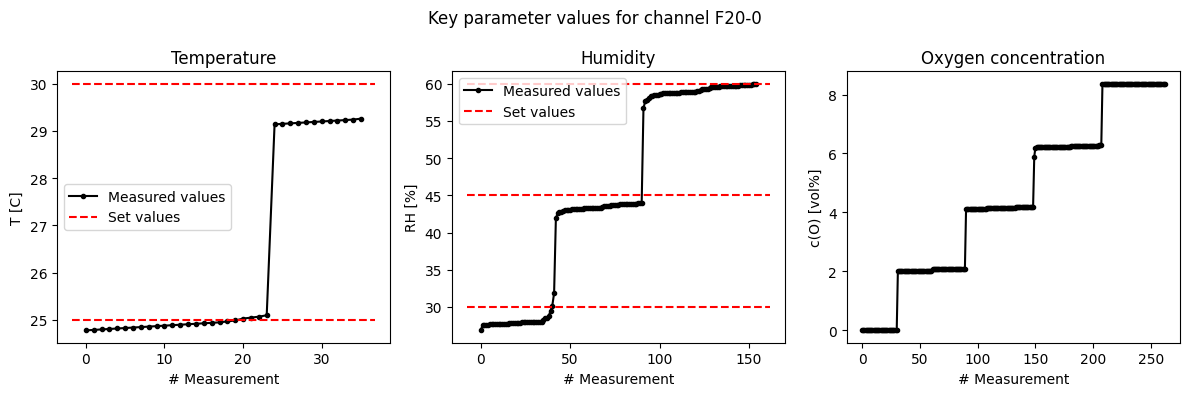

In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

bax = ax[0]
bax.plot(par_vals['t_sht'], color='k', marker='.', label='Measured values')
bxlim = bax.get_xlim()
for i, v in enumerate(par_vals['set_temp']):
    if i==0:
        bax.plot(bxlim, v*np.ones(2), color='r', linestyle='--', label='Set values')
    else:
        bax.plot(bxlim, v*np.ones(2), color='r', linestyle='--')
bax.set_title('Temperature')
bax.set_ylabel('T [C]')
bax.set_xlabel('# Measurement')
bax.legend()
    
bax = ax[1]
bax.plot(par_vals['h_sht'], color='k', marker='.', label='Measured values')
bxlim = bax.get_xlim()
for i, v in enumerate(par_vals['set_RH']):
    if i==0:
        bax.plot(bxlim, v*np.ones(2), color='r', linestyle='--', label='Set values')
    else:
        bax.plot(bxlim, v*np.ones(2), color='r', linestyle='--')
bax.set_title('Humidity')
bax.set_ylabel('RH [%]')
bax.set_xlabel('# Measurement')
bax.legend()
    
bax = ax[2]
bax.plot(par_vals['c_ox'], color='k', marker='.')
bax.set_title('Oxygen concentration')
bax.set_ylabel('c(O) [vol%]')
bax.set_xlabel('# Measurement')

fig.suptitle('Key parameter values for channel F20-0')

plt.tight_layout()

Now we know that there should be 5 distinct values of c_ox, which helps us visualize the relationship between the oxygen concentration and the recorded signals.

Below we sweep through measurements of all 4 sensors and for each of them determine the 5 characteristic values of c_ox (for this we use the KMeans function from sklearn). 

We use this information to group the recorded signals into 5 colors, depending on to which of the 5 characteristic c_ox values is the given value the closest. 

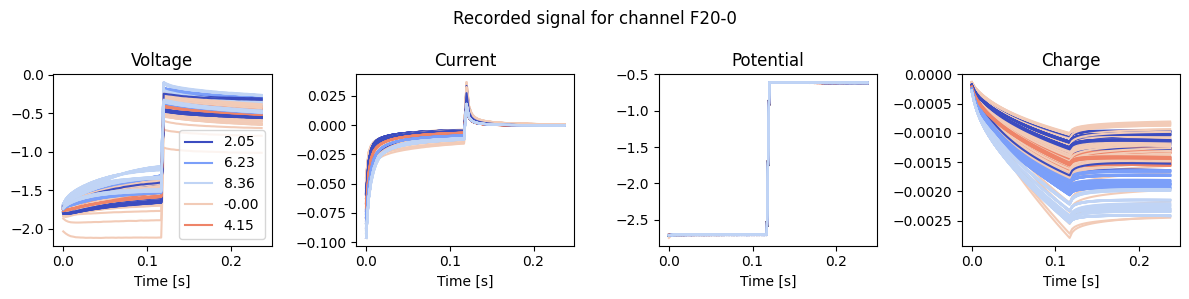

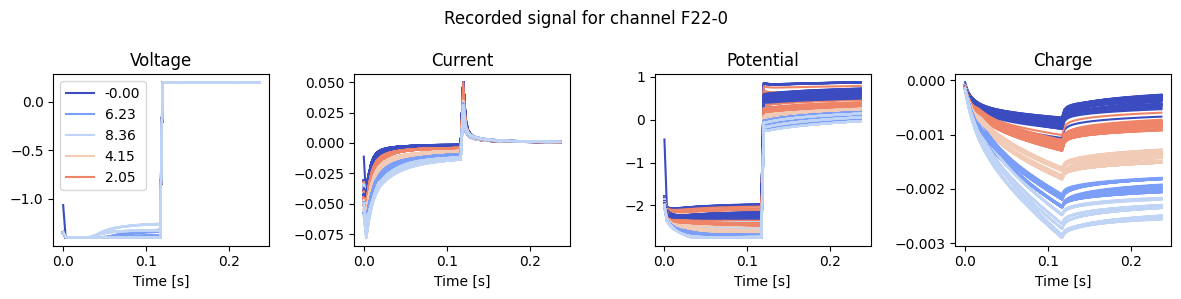

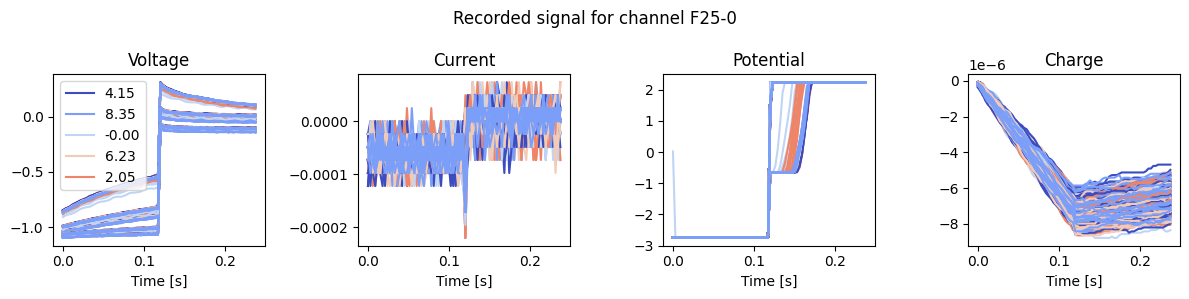

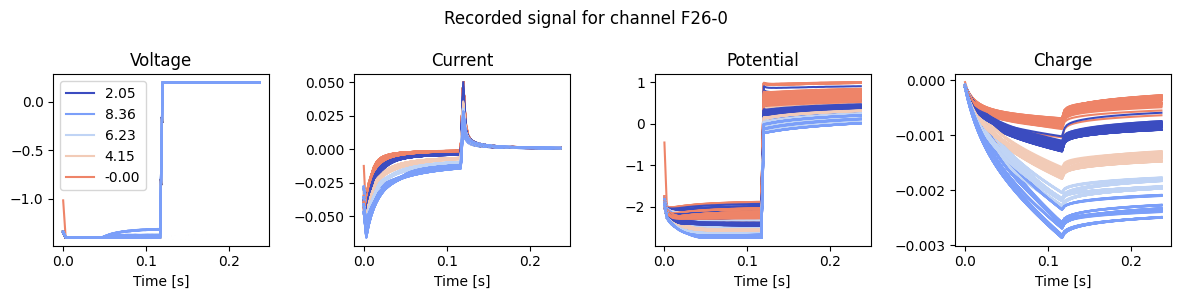

In [8]:
N_c_ox = 5

cmap1 = plt.cm.coolwarm
colors = cmap1(np.arange(0, 255, 256//(N_c_ox)))



channel_names = ['F20-0', 'F22-0', 'F25-0', 'F26-0']
channel_measurements = [mf20, mf22, mf25, mf26]

for im, ms in enumerate(channel_measurements):

    Nmeas = len(ms)


    # determine the 5 c_ox values
    c_ox = np.zeros(Nmeas, dtype=np.float64)
    for i, m in enumerate(ms):
        c_ox[i] = m.pars['c_ox']


    kmean = KMeans(n_clusters=N_c_ox).fit(c_ox.reshape(-1, 1))
    c_ox_cents = kmean.cluster_centers_.reshape(-1)

    fig, ax = plt.subplots(ncols=4, figsize=(12, 3))

    ax = ax.flatten()

    bax = ax[0]
    for i, m in enumerate(ms):
        bax.plot(m.time, m.voltage, color=colors[kmean.labels_[i]])
    bxlim = bax.get_xlim()
    bylim = bax.get_ylim()
    for ic in range(N_c_ox):
        bax.plot(2*bxlim[1]*np.array((1, 1.001)), 
                 2*bylim[1]*np.array((1, 1.001)),  
                 color=colors[ic], label=f'{c_ox_cents[ic]:.2f}')
    bax.set_xlim(bxlim)
    bax.set_ylim(bylim)
    bax.set_title('Voltage')
    bax.set_xlabel('Time [s]')
    bax.legend()

    bax = ax[1]
    for i, m in enumerate(ms):
        bax.plot(m.time, m.current, color=colors[kmean.labels_[i]])
    bax.set_title('Current')
    bax.set_xlabel('Time [s]')

    bax = ax[2]
    for i, m in enumerate(ms):
        bax.plot(m.time, m.potential, color=colors[kmean.labels_[i]])
    bax.set_title('Potential')
    bax.set_xlabel('Time [s]')
    
    bax = ax[3]
    for i, m in enumerate(ms):
        bax.plot(m.time, np.cumsum(m.current)*(m.time[1]-m.time[0]), color=colors[kmean.labels_[i]])
    bax.set_title('Charge')
    bax.set_xlabel('Time [s]')
    
    fig.suptitle(f'Recorded signal for channel {channel_names[im]}')

    plt.tight_layout()

The above plots show that the sensor response (current, charge and potential) curves feature a separation depending on the value of c_ox (although there is also some notable overlap).  

To analyze in detail the relationship between the oxygen concentration, temperature and humidity and the recorded signals, we will consider 3 response signals:

1. Charge (defined as the cummulative sum of the current)
2. Current
3. Potential (the 'CEPotential' values)

Moreover, we shall monitor the values of these signals at 2 conveniently selected points in time, which we shall denote by t1 and t2. 

To represent this data, we shall introduce a new class which we call SensorData. Each SensorData object will contain measurement information for a single specified sensor. Instead of keeping track of all the response transient data, only the values at the specified monitors will be kept in the SensorData object. The idea is that each measurement involving the specified sensor is represented exactly once in SensorData, whereby the following is recorded:

1. control_pars - dictinary whose fields are the arrays of values of control parameters 'c_ox', 't_sht', 'h_sht' from each of the measurements; 
                
                control_pars['c_ox'] - (float array) of c_ox values (lenght 300)
                control_pars['t_sht'] - (float array) of t_sht values (lenght 300)
                control_pars['h_sht'] - (float array) of h_sht values (length 300)

2. responses - dictionary containing the values of response signals (charge, current and potential) recorded at t1 or t2 ('charge_t1', 'charge_t2', 'current_t1', 'current_t2', 'potential_t1', 'potential_t2'). 

                responses['charge_t1'] - (float array) of charge_t1 values (length 300)
                responses['charge_t2'] - (float array) of charge_t2 values (length 300)
                responses['current_t1'] - (float array) of current_t1 values (length 300)
                responses['current_t2'] - (float array) of current_t2 values (length 300)
                responses['potential_t1'] - (float array) of potential_t1 values (length 300)
                responses['potential_t2'] - (float array) of potential_t2 values (length 300)
                
Since a SensorData object contains all the data that we need for our analysis, we define two auxiliary methods, eval_corr and eval_lin_regression which we use to study the mutual dependence between the listed control parameters and response signal.

In [9]:
class SensorData:
    def __init__(self, channel, measurements_all=[], idx_t1=38, idx_t2=79):
        """
        
        Input:
        channel - (str) - one of 'F20-0', 'F22-0', 'F25-0', 'F26-0'
        measurements_all - (list of Measurement) list of measurement objects to be considered
        idx_t1 - (int) - in [0, 79] index of the monitoring point (in time) at which the signal 
                        ("descriptive parameter") is considered; two points are considered 
                        (to compare the signal at low and high voltages)
        idx_t2 - (int) - same as idx_t2, for defining the second monitor; the general idea is to
                        have idx_t1 in the range of low voltages and idx_t2 in the range of high
                        voltages, but this is arbitrary as any two points can be selected
                        
        
        """
        
        self.channel = channel
        self.idx_t1 = idx_t1
        self.idx_t2 = idx_t2
        self.t1 = measurements_all[0].time[idx_t1]
        self.t2 = measurements_all[0].time[idx_t2]
        
        
        measurements = []
        for m in measurements_all:
            if m.pars['channel'] == channel:
                measurements.append(m)
        
        Nmeas = len(measurements)
        self.Nmeas=Nmeas
        # print(f'Creating sensor data with {Nmeas} measurements.')
        
        self.control_par_names = ['c_ox', 't_sht', 'h_sht']
        
        self.control_pars = {}
        
        for k in self.control_par_names:
            self.control_pars[k] = np.zeros(Nmeas, dtype=np.float64)

       
        # responses
        self.response_names = ['charge_t1', 'charge_t2', 'current_t1', 'current_t2',
                         'potential_t1', 'potential_t2']
        
        self.responses = {}
        for k in self.response_names:
            self.responses[k] = np.zeros(Nmeas, dtype=np.float64)

        
        for i, m in enumerate(measurements):
            for k in self.control_par_names:
                self.control_pars[k][i] = m.pars[k]
            
            buf_charge = np.cumsum(m.current)*(m.time[1]-m.time[0])
            self.responses['charge_t1'][i] = buf_charge[idx_t1]
            self.responses['charge_t2'][i] = buf_charge[idx_t2]
            self.responses['current_t1'][i] = m.current[idx_t1]
            self.responses['current_t2'][i] = m.current[idx_t2]
            self.responses['potential_t1'][i] = m.potential[idx_t1]
            self.responses['potential_t2'][i] = m.potential[idx_t2]
            
   
    def eval_corr(self):
        """
        Evaluate the correlation coefficients between the control parameters ('c_ox', 't_sht' and 
            'h_sht') and response signals (charge, current and potential) at t1 = m.time[idx_t1] and 
            t2 = m.time[idx_t2]
        """
        
        print('\n')
        print(80*'=')
        print(2*' '+ f'Correlation table for [{self.channel}], ', end='')
        print(f'(it1, it2)=({self.idx_t1}, {self.idx_t2}), (t1, t2)=({self.t1:.2f}s, {self.t2:.2f}s)')
        print(80*'-')
        print('\t\t', end='')
        for k_cont in self.control_par_names:
            print(f'\t{k_cont}', end='\t')
        for k_resp in self.response_names:
            print(80*'-')
            print(f'{k_resp}', end='\t')
            for k_cont in self.control_par_names:
                r = np.corrcoef(self.control_pars[k_cont], self.responses[k_resp])[0, 1]
                
                print(f'\t{r:.3f}', end='\t')
            print('')
        print(80*"=")
        print('\n')
        
        
    def eval_lin_regression(self, include_t=False, include_h=False, normalize_controls=False,
                       normalize_response=False, plot_table=True):
        """
        Carry out linear regression between control parameters and response signals and plot out
            the data in a table.
            
        Input:
        include_t - (boolean) if set to True, the temperature ('t_sht') is included in regression analysis.
                        Used for purposes of testing the dependence between t_sht and response signals.
        include_h - (boolean) if set to True, the humidity ('h_sht') is included in regression analysis.
                        Used for purposes of testing the dependece between h_sht and response signals.
        normalize_controls - (boolean) if set to True, the control signals are normalized
        normalize_response - (boolean) if set to True, the response signals are normalized 
                        Useful for comparing MAE, RMSE and R2 metrics for different response signals.
        plot_table - (boolean) if True, the regression table is shown
        """
        
        X = np.zeros(shape=(self.Nmeas, 3), dtype=np.float64)
        Y = np.zeros(self.Nmeas, dtype=np.float64)

        X[:, 0] = self.control_pars['c_ox']
        if include_t:
            X[:, 1] = self.control_pars['t_sht']
        else:
            X[:, 1] = 0
            
        if include_h:
            X[:, 2] = self.control_pars['h_sht']
        else:
            X[:, 2] = 0
        
        if normalize_controls:
            scaler = StandardScaler()
            X_norm = scaler.fit_transform(X)
        else:
            X_norm = X

      
        self.fits = {}
        self.fit_pars = {}
        for k in self.response_names:
            self.fits[k] = np.zeros(self.Nmeas, dtype=np.float64)
            self.fit_pars[k]={}
        
        if plot_table:
            print('\n')
            print(110*'=')
            print(20*' '+ f'Regression table for [{self.channel}], ', end='')
            print(f'(it1, it2)=({self.idx_t1}, {self.idx_t2}), (t1, t2)=({self.t1:.2f}s, {self.t2:.2f}s)')
            print(110*'-')
            print('\t\t', end='')
            print('  MAE \t\t  RMSE\t\tR2 score', end='')
            for k_cont in self.control_par_names:
                print(f'\tcoef({k_cont})', end='')
            print('')    
        for k_resp in self.response_names:
            
            Y[:] = self.responses[k_resp]
            
            if normalize_response:
                Y = (Y-np.mean(Y))/np.std(Y)

            model = LinearRegression()
            model.fit(X_norm, Y)
            Yhat = model.predict(X_norm)
            
            self.fits[k_resp][:] = Yhat[:]
            self.fit_pars[k_resp]['coef'] = model.coef_
            self.fit_pars[k_resp]['intercept'] = model.intercept_
            
            rmse = root_mean_squared_error(Y, Yhat)
            mae = mean_absolute_error(Y, Yhat)
            r2 = r2_score(Y, Yhat)
            
            self.fit_pars[k_resp]['RMSE'] = rmse
            self.fit_pars[k_resp]['MAE'] = mae
            self.fit_pars[k_resp]['R2'] = r2

            if plot_table:
           
                print(110*'-')
                print(f'{k_resp}', end='\t')
                print(f'{mae:.3e} \t {rmse:.3e} \t {r2:.3e} ', end='')
                for i, k_cont in enumerate(self.control_par_names):
                    # r = np.corrcoef(self.control_pars[k_cont], self.responses[k_resp])[0, 1]

                    print(f'\t{model.coef_[i]:.3e}', end='')
                print('')
        if plot_table:
            print(110*"=")
            print('\n')
        

We are now ready to visualize the recorded signal as a function of oxygen concentration for each channel (task 1).



  Correlation table for [F20-0], (it1, it2)=(38, 79), (t1, t2)=(0.11s, 0.24s)
--------------------------------------------------------------------------------
			c_ox		t_sht		h_sht	--------------------------------------------------------------------------------
charge_t1		-0.759		-0.253		-0.080	
--------------------------------------------------------------------------------
charge_t2		-0.841		-0.232		-0.103	
--------------------------------------------------------------------------------
current_t1		-0.760		-0.212		-0.052	
--------------------------------------------------------------------------------
current_t2		-0.483		0.020		-0.115	
--------------------------------------------------------------------------------
potential_t1		-0.099		-0.946		-0.015	
--------------------------------------------------------------------------------
potential_t2		-0.301		-0.819		-0.074	




                    Regression table for [F20-0], (it1, it2)=(38, 79), (t1, t2)=(0.11s, 0.24s)
---------------

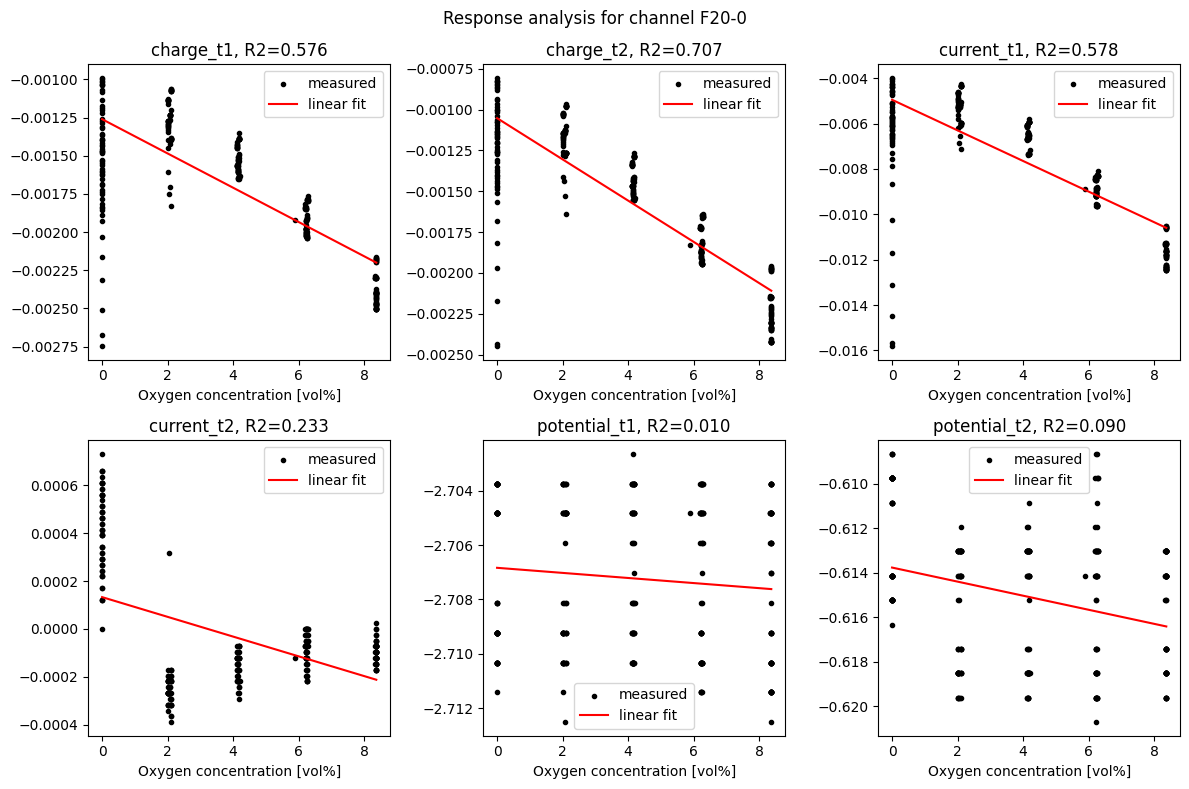

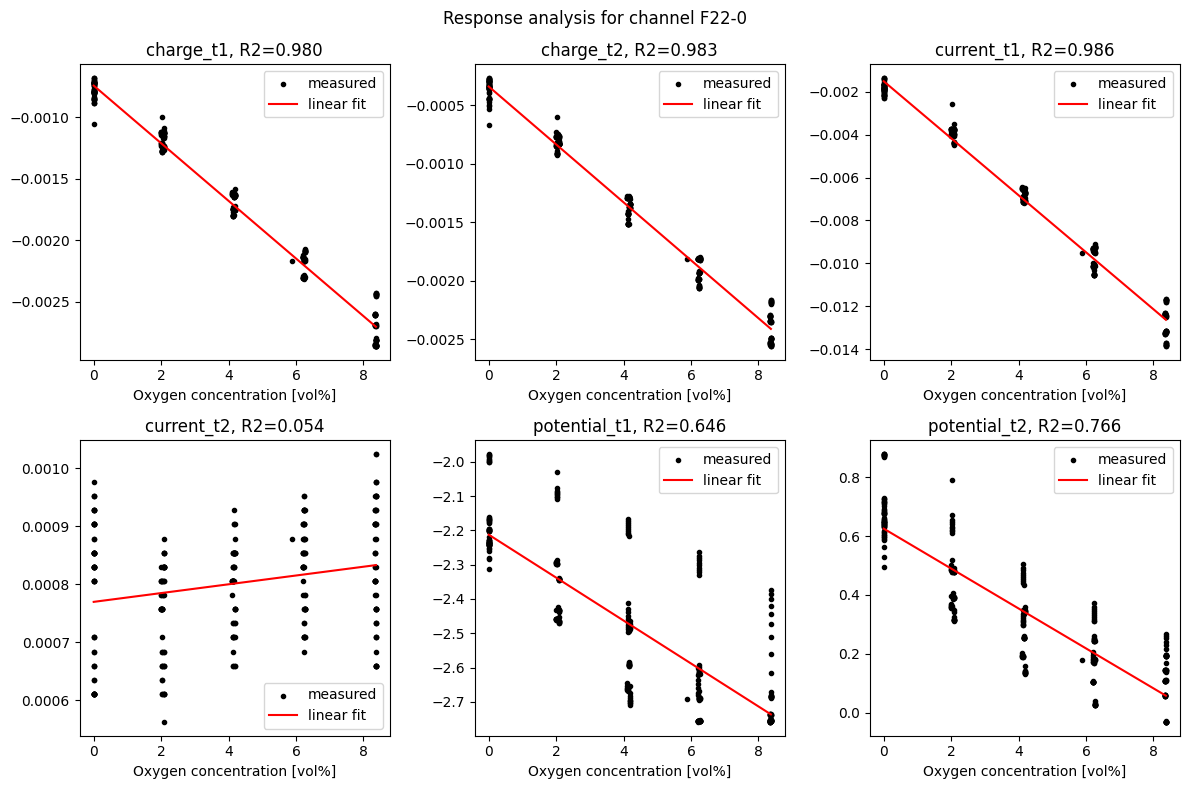

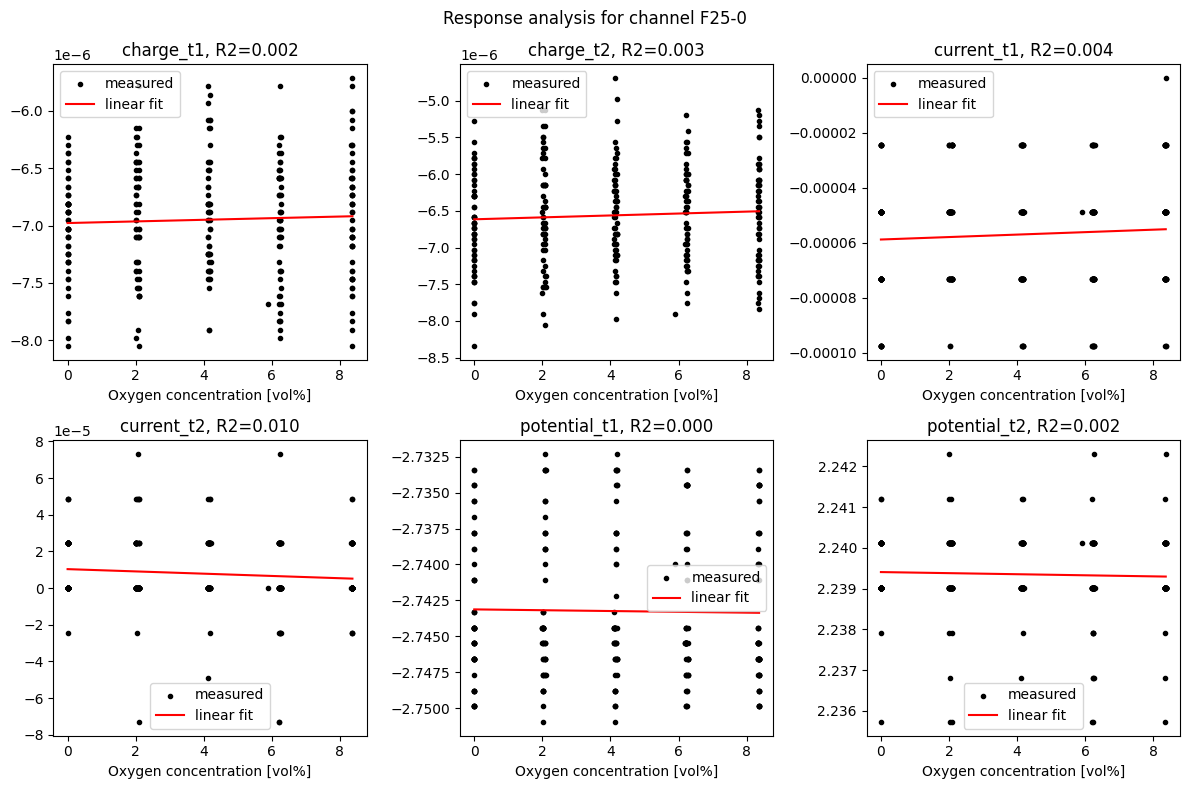

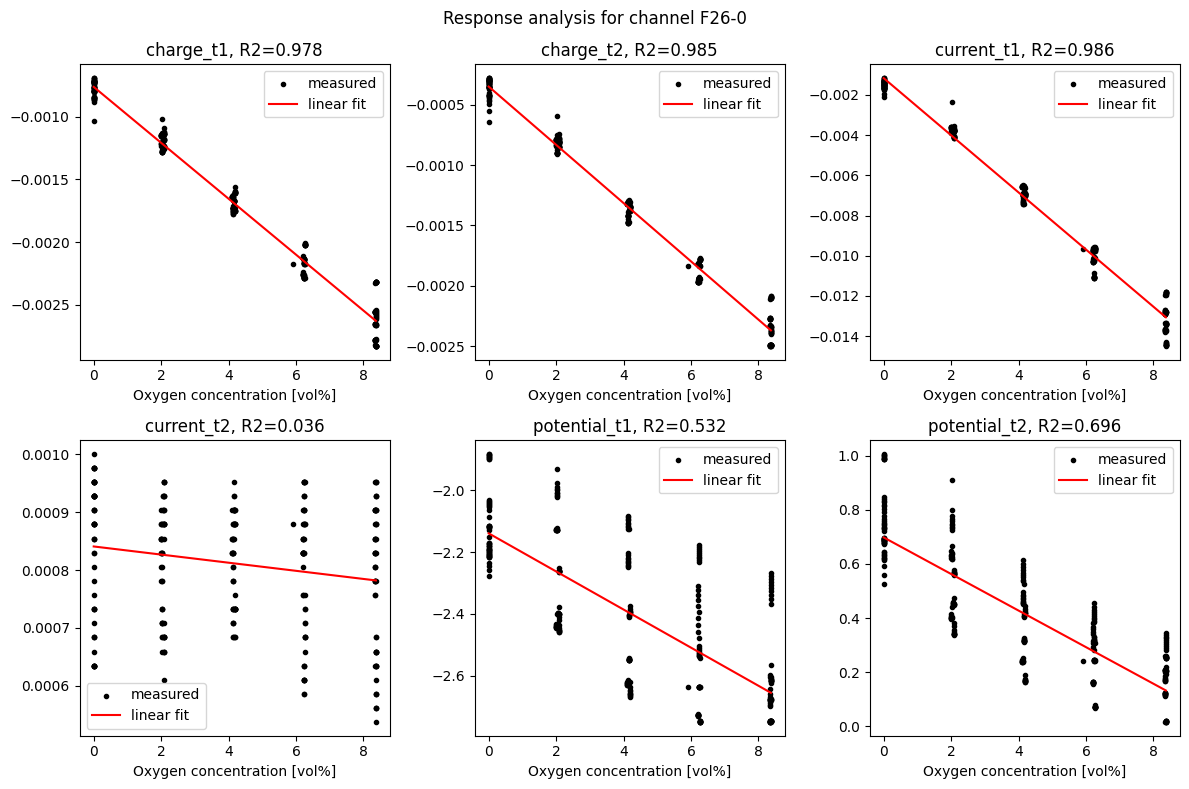

In [10]:
channel_names = ['F20-0', 'F22-0', 'F25-0', 'F26-0']

for channel in channel_names:

    sd = SensorData(channel=channel, measurements_all=measurements_all, idx_t1=38, idx_t2=79)
    sd.eval_corr()
    sd.eval_lin_regression(normalize_response=False)

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    ax = ax.flatten()

    for i, k in enumerate(sd.responses.keys()):
        if i==0:
            bc = np.linspace(np.min(sd.control_pars['c_ox']), np.max(sd.control_pars['c_ox']), 100)
        bax = ax[i]
        bax.scatter(sd.control_pars['c_ox'], sd.responses[k], color='k', marker='.', label='measured')
        bax.plot(bc, sd.fit_pars[k]['coef'][0]*bc+sd.fit_pars[k]['intercept'], color='r', label='linear fit')
        bax.set_title(f"{k}, R2={sd.fit_pars[k]['R2']:.3f}")
        bax.set_xlabel('Oxygen concentration [vol%]')
        bax.legend()

    fig.suptitle(f'Response analysis for channel {sd.channel}')

    plt.tight_layout()

<font color='red'>The above tables and plots contain most of the relevant data based on which we discuss the following tasks.</font>

## Task 2: Determine which polarization step is most effective for sensing oxygen levels

Looking at the plots of response transients (plots called 'Recorded signal for channel F2X-0' above), we get the impression that the best separation of the response into groups corresponding to different c_ox values is obtained for the current in the low polarization step (e.g. t=0.11s) or for the current at the end of the recorded range (e.g. t=0.24s). 

However, to formally resolve this question, we will consider the regression table showing the calibration quality metrics (obtained by fitting a linear function of c_ox to the observed response signal values). To have a fair comparison of MAE and RMSE metrics for different response signals, we normalize them (the normalize_response flag in the .eval_lin_regression method below).

The most relevant metric for assessing the sensing effectiveness is the R2 score. 

We find that for:

<b>F20-0</b>: by far the best R2 score (0.7075) is obtained for charge_t2 (i.e. monitoring charge at the end of the high/positive polarization step).

<b>F22-0</b>: the best R2 score (9.856e-01) is obtained for current_t1 (i.e. monitoring the current at the end of the low/negative polarization step), although charge_t1 and charge_t2 are practically equally good.

<b>F25-0</b>: this sensor is evidently corrupt (also confirmed by very low R2 score values in the 1e-3 range)

<b>F26-0</b>: similarly to F22-0, the best R2 score (9.859e-01) is obtained for current_t1 (i.e. monitoring the current at the end of the low/negative polarization step), although charge_t1 and charge_t2 are practically equally good.

In all 4 cases the above conclusions based on the R2 score are further corroborated by the MAE and RMSE metrics (which is possible because we have normalized the response).

In summary, if a single best response signal is to be considered for sensing, it should be charge_t2. If, however, we can select different response signals for different sensors, the presented data suggests that using current_t1 is marginally better for F22-0 and F26-0.

In [11]:
channel_names = ['F20-0', 'F22-0', 'F25-0', 'F26-0']

for channel in channel_names:

    sd = SensorData(channel=channel, measurements_all=measurements_all, idx_t1=38, idx_t2=79)
    # sd.eval_corr()
    sd.eval_lin_regression(normalize_response=True)



                    Regression table for [F20-0], (it1, it2)=(38, 79), (t1, t2)=(0.11s, 0.24s)
--------------------------------------------------------------------------------------------------------------
		  MAE 		  RMSE		R2 score	coef(c_ox)	coef(t_sht)	coef(h_sht)
--------------------------------------------------------------------------------------------------------------
charge_t1	4.887e-01 	 6.509e-01 	 5.763e-01 	-2.569e-01	0.000e+00	0.000e+00
--------------------------------------------------------------------------------------------------------------
charge_t2	3.921e-01 	 5.409e-01 	 7.075e-01 	-2.846e-01	0.000e+00	0.000e+00
--------------------------------------------------------------------------------------------------------------
current_t1	4.381e-01 	 6.498e-01 	 5.777e-01 	-2.572e-01	0.000e+00	0.000e+00
--------------------------------------------------------------------------------------------------------------
current_t2	7.108e-01 	 8.755e-01 	 2.335e-01 	-1.635e-01	

## Task 3: Identify and visualize any apparent dependencies in the data

To quantify the dependencies between the control parameters and response signals, we consider the Pearson correlation coefficients shown in tables below, generated using the .eval_corr() method of the SensorData class.

Since F25-0 is evidently corrupt, we exclude it from the discussion.

We find that c_ox is highly correlated (|r|>=0.75) with charge_t1, charge_t2 and current_t1, while in the case of current_t2, potential_t1 and potential_t2 there is at least one case in which |r| is around 0.3 or less.

The fact that charge_t1, charge_t2 and current_t1 have the strongest correlation with c_ox is obviously consistent with the regression analysis we considered in Task 2.

In terms of the influence of the temperature and humidity, it makes most sense to consider only charge_t1, charge_t2 and current_t1, since the remaining response signals are now useful for detecting c_ox. For all three response signals, it is evident that the <b>correlation with temperature is much higher than with humidity</b>, especially for F20-0 and F22-0 where |r| between the signal and t_sht is above 0.2 and around 0.1, respectively, while the corresponding correlation with humidity is 2 or more times lower. 

Further insight can be obtained by considering the regression tables and setting the include_t and include_h flags to True (so we can see how much better can we predict the response if the temperature and humidity are assumed known), but is not necessary here.

In [12]:
channel_names = ['F20-0', 'F22-0', 'F25-0', 'F26-0']

for channel in channel_names:

    sd = SensorData(channel=channel, measurements_all=measurements_all, idx_t1=38, idx_t2=79)
    sd.eval_corr()



  Correlation table for [F20-0], (it1, it2)=(38, 79), (t1, t2)=(0.11s, 0.24s)
--------------------------------------------------------------------------------
			c_ox		t_sht		h_sht	--------------------------------------------------------------------------------
charge_t1		-0.759		-0.253		-0.080	
--------------------------------------------------------------------------------
charge_t2		-0.841		-0.232		-0.103	
--------------------------------------------------------------------------------
current_t1		-0.760		-0.212		-0.052	
--------------------------------------------------------------------------------
current_t2		-0.483		0.020		-0.115	
--------------------------------------------------------------------------------
potential_t1		-0.099		-0.946		-0.015	
--------------------------------------------------------------------------------
potential_t2		-0.301		-0.819		-0.074	




  Correlation table for [F22-0], (it1, it2)=(38, 79), (t1, t2)=(0.11s, 0.24s)
--------------------------------

## Task 4: Detect and flag any corrupted sensors

Based on the plot of the transient response in the plot called 'Recorded signal for channel F25-0', as well as on the correlation and regression tables for this sensor, we see clearly that <b>the F25-0 sensor is corrupt</b>.

In terms of quality, it is evident that F22-0 and F26-0 are quite good, while F20-0 is notably worse (R2 score for regression between charge_t2 and c_ox is 7.075e-01) so <b>F20-0 is likely to be close to a border of acceptable performance</b>.

## Task 5: Attempt to calibrate the functional sensors and evaluate the oxygen level calibration quality using metrics such as MAE, RMSE, R2, etc.

To calibrate the functional sensors ('F20-0', 'F22-0', 'F26-0') we use the .eval_lin_regression() method of the SensorData class and consider the mentioned 3 promising response signals ('charge_t1', 'charge_t2', 'current_t1').

Below we see that F20-0 cannot be used for detecting lower oxygen concentrations, but that F22-0 and F26-0 are quite decent. The R2 scores are shown in the graphs, while the other metrics (MAE, RMSE) is not shown as it is identical to values shown in the regression tables above. These tables can be re-generated below by setting the plot_table flag of .eval_lin_regression to True.

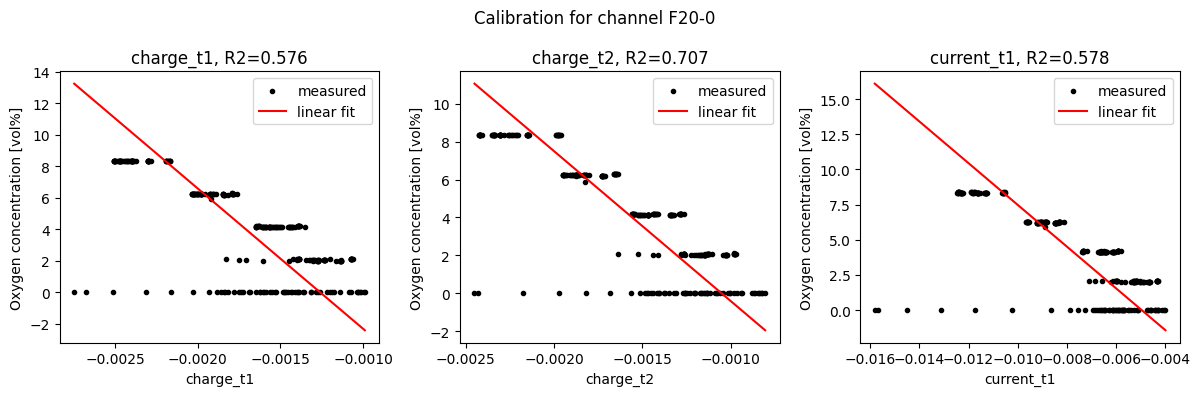

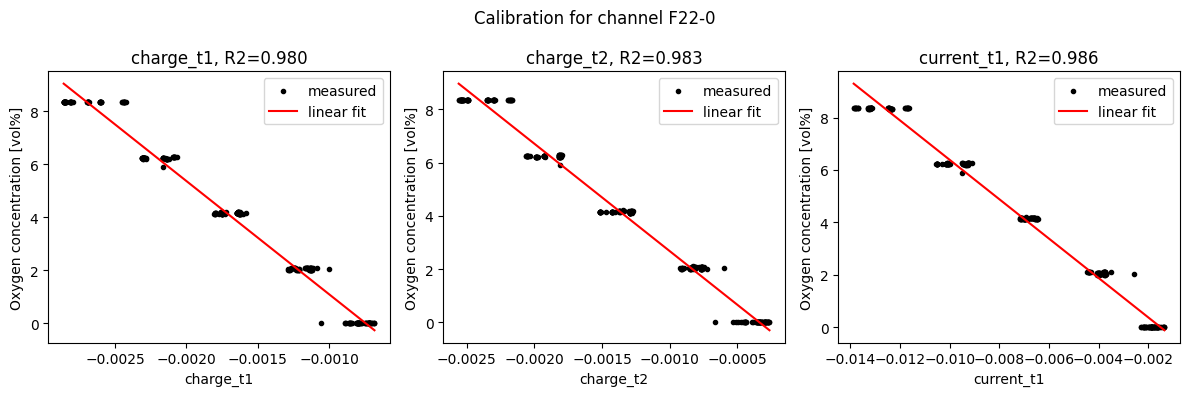

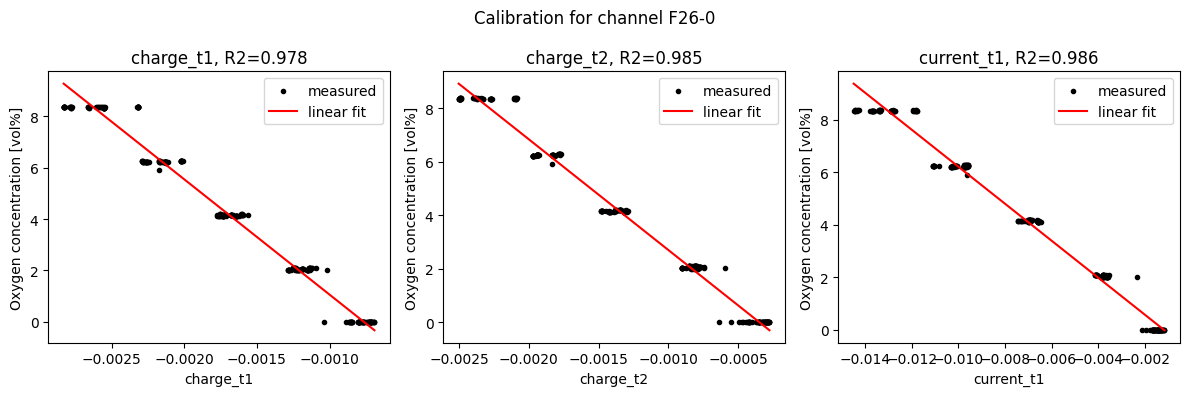

In [13]:
channel_names = ['F20-0', 'F22-0', 'F26-0']

response_names = ['charge_t1', 'charge_t2', 'current_t1']

for channel in channel_names:

    sd = SensorData(channel=channel, measurements_all=measurements_all, idx_t1=38, idx_t2=79)
    # sd.eval_corr()
    sd.eval_lin_regression(normalize_response=False, plot_table=False)

    fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
    ax = ax.flatten()


    for i, k in enumerate(response_names):

        br = np.linspace(np.min(sd.responses[k]), np.max(sd.responses[k]), 100)
        bax = ax[i]
        bax.scatter(sd.responses[k], sd.control_pars['c_ox'], color='k', marker='.', label='measured')
        bax.plot(br, (br-sd.fit_pars[k]['intercept'])/sd.fit_pars[k]['coef'][0], color='r', label='linear fit')
        bax.set_title(f"{k}, R2={sd.fit_pars[k]['R2']:.3f}")
        bax.set_ylabel('Oxygen concentration [vol%]')
        bax.set_xlabel(k)
        bax.legend()

    fig.suptitle(f'Calibration for channel {sd.channel}')

    plt.tight_layout()

## Task 6: Considering the intentional addition of moisture to the supplied gas, please describe its potential impact on the absolute values of oxygen concentration, effect on calibration, and how it can be accounted for.

In the analysis above, the relative humidity is found to have a considerably lower correlation coefficient with the response signal than the oxygen concentration or temperature. However, the addition of moisture to the supplied gas will change (reduce) the oxygen concentration, so a proper account of moisture (if changed in a considerable range) has to take into account this direct effect, i.e. the oxygen concentration should be monitored by a reference sensor. Then, the values read from the reference sensor can be used for calibration, in a manner analoguos to the one considered here.